In [1]:
%matplotlib inline
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image, Audio, clear_output

import math

import pickle

import itertools

import zipfile

from node2vec import Node2Vec

import os

from scipy import sparse

import time

from ast import literal_eval as make_tuple

from sklearn import preprocessing, decomposition, cluster, manifold, neighbors, metrics

from zipfile import ZipFile

import imageio

import shutil

import networkx as nx
from networkx.algorithms import community
import community as cm

from tqdm import tnrange, tqdm_notebook, tqdm

import dask.dataframe as dd

import seaborn as sbs

import collections

import torch
import torch.nn as nn
# from torch.utils.data import DataLoader, Dataset

import torch_geometric.nn as gnn
from torch_geometric.data import Data, DataLoader, Dataset

In [2]:
torch.cuda.get_device_name(0)

GPU = True
device_idx = 1
if GPU:
    device = torch.device("cuda:" + str(device_idx - 1) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

print(device)

cuda:0


In [3]:
# network = nx.Graph(nx.read_graphml("dyngem_graphs/0.graphml"))

# attrs = [nx.get_node_attributes(network, 'apt_markakis')[i] for i in network.nodes]

# nx.draw_kamada_kawai(network, node_size=15, node_color=attrs)

# plt.show()

In [4]:
def wider_input(new_dim, ae):
    new_layers = new_dim - ae.linear1.lin.weight.shape[1]

    if new_layers <= 0:
#         print("returning")
        return ae
    new_indices = list(np.random.choice(ae.linear1.lin.weight.shape[1], new_layers, replace=True))

    weights = ae.linear1.lin.weight
    weights = torch.transpose(weights, 0, 1)
    biases = ae.linear1.lin.bias

    counts = [(i, new_indices.count(i)) for i in new_indices]


    new_weights = []

    for i in counts:
        weights[i[0]] *= 1/(1+i[1])
        new_weight = (weights[i[0]] * 1/(1+i[1])).view(1,-1)
        new_weights.append(new_weight)

    new_weights = torch.cat(new_weights)
    new_weights = torch.cat([weights, new_weights])
#     new_weights = new_weights + torch.randn(new_weights.shape).to(device) * 0.1
    new_weights = torch.transpose(new_weights, 0, 1)

    biases = biases * ae.linear1.lin.weight.shape[1] / new_dim
#     biases = biases + torch.randn(biases.shape).to(device) * 0.1

#     ae.linear1.lin.in_features = new_dim
    ae.linear1.in_channels = new_dim
    ae.linear1.lin.in_channels = new_dim
    ae.linear1.lin.bias = torch.nn.Parameter(biases)
    ae.linear1.lin.weight = torch.nn.Parameter(new_weights)
    return ae
    
def wider_output(new_dim, ae):
    
    new_layers = new_dim - ae.linear4.lin.weight.shape[0]
    if new_layers <= 0:
        return ae
    new_indices = list(np.random.choice(ae.linear4.lin.weight.shape[0], new_layers, replace=True))

    weights = ae.linear4.lin.weight
#     weights = torch.transpose(weights, 0, 1)
    biases = ae.linear4.lin.bias

    counts = [(i, new_indices.count(i)) for i in new_indices]

    new_biases = []
    new_weights = []

    for i in counts:
        weights[i[0]] *= 1/(1+i[1])
        new_weight = (weights[i[0]] * 1/(1+i[1])).view(1,-1)
        new_weights.append(new_weight + torch.randn(new_weight.shape).to(device) * 0.1)
        
        biases[i[0]] *= 1/(1+i[1])
        new_bias = (biases[i[0]] * 1/(1+i[1])).view(1,-1)
        new_biases.append(new_bias + torch.randn(new_bias.shape).to(device) * 0.1)


    new_weights = torch.cat(new_weights)
    new_weights = torch.cat([weights, new_weights])
#     new_weights = torch.transpose(new_weights, 0, 1)
#     new_weights = new_weights + torch.randn(new_weights.shape).to(device) * 0.1
    
    new_biases = torch.cat(new_biases).view(-1)
    new_biases = torch.cat([biases, new_biases])
#     new_biases = new_biases + torch.randn(new_biases.shape).to(device) * 0.1

    ae.linear4.out_features = new_dim
    ae.linear4.out_channels = new_dim
    ae.linear4.lin.bias = torch.nn.Parameter(new_biases)
    ae.linear4.lin.weight = torch.nn.Parameter(new_weights)
    return ae

def wider_decode(new_dim, ae):
        
    new_layers = new_dim - ae.decode_linear.weight.shape[0]
    if new_layers <= 0:
        return ae
    new_indices = list(np.random.choice(ae.decode_linear.weight.shape[0], new_layers, replace=True))

    weights = ae.decode_linear.weight
#     weights = torch.transpose(weights, 0, 1)
    biases = ae.decode_linear.bias

    counts = [(i, new_indices.count(i)) for i in new_indices]

    new_biases = []
    new_weights = []

    for i in counts:
        weights[i[0]] *= 1/(1+i[1])
        new_weight = (weights[i[0]] * 1/(1+i[1])).view(1,-1)
        new_weights.append(new_weight + torch.randn(new_weight.shape).to(device) * 0.01)
        
        biases[i[0]] *= 1/(1+i[1])
        new_bias = (biases[i[0]] * 1/(1+i[1])).view(1,-1)
        new_biases.append(new_bias + torch.randn(new_bias.shape).to(device) * 0.01)


    new_weights = torch.cat(new_weights)
    new_weights = torch.cat([weights, new_weights])
#     new_weights = torch.transpose(new_weights, 0, 1)
#     new_weights = new_weights + torch.randn(new_weights.shape).to(device) * 0.1
    
    new_biases = torch.cat(new_biases).view(-1)
    new_biases = torch.cat([biases, new_biases])
#     new_biases = new_biases + torch.randn(new_biases.shape).to(device) * 0.1

    ae.decode_linear.out_features = new_dim
    ae.decode_linear.out_channels = new_dim
    ae.decode_linear.bias = torch.nn.Parameter(new_biases)
    ae.decode_linear.weight = torch.nn.Parameter(new_weights)
    return ae

def wider_cheb_input(new_dim, ae):
        
    new_layers = new_dim - ae.linear1.weight.shape[1]
    if new_layers <= 0:
        return ae
    new_indices = list(np.random.choice(ae.linear1.weight.shape[1], new_layers, replace=True))

    weights = ae.linear1.weight.detach()
#     weights = torch.transpose(weights, 0, 1)
#     biases = ae.linear1.bias

    counts = [(i, new_indices.count(i)) for i in new_indices]

#     new_biases = []
    new_weights = []

    for i in counts:
        weights[:, i[0]] *= 1/(1+i[1])
        new_weight = (weights[:, i[0]] * 1/(1+i[1])).view(weights.shape[0],1,-1)
        
        new_weights.append(new_weight + torch.randn(new_weight.shape).to(device) * 0.01)
        
#         biases[i[0]] *= 1/(1+i[1])
#         new_bias = (biases[i[0]] * 1/(1+i[1])).view(1,-1)
#         new_biases.append(new_bias + torch.randn(new_bias.shape).to(device) * 0.1)


    new_weights = torch.cat(new_weights, dim=1)
    new_weights = torch.cat([weights, new_weights], dim=1)
    
#     new_weights = torch.transpose(new_weights, 0, 1)
#     new_weights = new_weights + torch.randn(new_weights.shape).to(device) * 0.1
    
#     new_biases = torch.cat(new_biases).view(-1)
#     new_biases = torch.cat([biases, new_biases])
#     new_biases = new_biases + torch.randn(new_biases.shape).to(device) * 0.1

    ae.linear1.in_channels = new_dim
#     ae.linear1.bias = torch.nn.Parameter(new_biases)
    ae.linear1.weight = torch.nn.Parameter(new_weights)
    return ae

def wider_cheb_output(new_dim, ae):
        
    new_layers = new_dim - ae.linear6.weight.shape[2]
    if new_layers <= 0:
        return ae
    new_indices = list(np.random.choice(ae.linear6.weight.shape[2], new_layers, replace=True))

    weights = ae.linear6.weight.detach()
#     weights = torch.transpose(weights, 0, 1)
    biases = ae.linear6.bias.detach()

    counts = [(i, new_indices.count(i)) for i in new_indices]

    new_biases = []
    new_weights = []

    for i in counts:
        weights[:, :, i[0]] *= 1/(1+i[1])
        new_weight = (weights[:, :, i[0]] * 1/(1+i[1])).view(weights.shape[0],-1,1)
        new_weights.append(new_weight + torch.randn(new_weight.shape).to(device) * 0.01)
        
        biases[i[0]] *= 1/(1+i[1])
        new_bias = (biases[i[0]] * 1/(1+i[1])).view(1,-1)
        new_biases.append(new_bias + torch.randn(new_bias.shape).to(device) * 0.01)


    new_weights = torch.cat(new_weights, dim=2)
    
    new_weights = torch.cat([weights, new_weights], dim=2)
    
#     new_weights = torch.transpose(new_weights, 0, 1)
#     new_weights = new_weights + torch.randn(new_weights.shape).to(device) * 0.1
    
    new_biases = torch.cat(new_biases).view(-1)
    new_biases = torch.cat([biases, new_biases])
#     new_biases = new_biases + torch.randn(new_biases.shape).to(device) * 0.1

    ae.linear6.out_channels = new_dim
    ae.linear6.bias = torch.nn.Parameter(new_biases)
    ae.linear6.weight = torch.nn.Parameter(new_weights)
    return ae

In [5]:
def neg_sin(x):
    return 0.025 * (torch.sin(x) - torch.cos(x))

def SineReLU(x):
    x[x < 0] = neg_sin(x[x < 0])
    return x


In [6]:
class VariationalEncoder(nn.Module):
    def __init__(self, hidden_size, input_dim, mid_layer, corrupt=0.01):
        super(VariationalEncoder, self).__init__()
        
        self.linear1 = gnn.ChebConv(input_dim, mid_layer, 3)
        self.b1 = nn.BatchNorm1d(mid_layer)
        self.conv2 = nn.Conv1d(1, hidden_size, 5, stride=2)
        self.b2 = nn.BatchNorm1d(hidden_size)
        self.conv3 = nn.Conv1d(hidden_size, int(hidden_size/2), 5, stride=2)
        self.b3 = nn.BatchNorm1d(int(hidden_size/2))
        self.conv4 = nn.Conv1d(int(hidden_size/2), 1, 3)
        num_lin = 123
        self.b4 = nn.BatchNorm1d(num_lin)
        self.linear1a = gnn.ChebConv(num_lin, hidden_size, 2)
        
        self.linear2 = gnn.ChebConv(hidden_size, num_lin, 2)
        self.b5 = nn.BatchNorm1d(num_lin)
        self.conv5 = nn.ConvTranspose1d(1, int(hidden_size/2), 3)
        self.b6 = nn.BatchNorm1d(int(hidden_size/2))
        self.conv6 = nn.ConvTranspose1d(int(hidden_size/2), hidden_size, 5, stride=2, output_padding=1)
        self.b7 = nn.BatchNorm1d(hidden_size)
        self.conv7 = nn.ConvTranspose1d(hidden_size, 1, 5, stride=2, output_padding=1)
        self.b8 = nn.BatchNorm1d(mid_layer)
        self.linear6 = gnn.ChebConv(mid_layer, input_dim, 3)
                                
#         self.activ = nn.ReLU()
        self.activ = SineReLU
    
        self.sp_linear = nn.Linear(hidden_size, 1)
        
    def encode(self, x, edges):
        
        x = self.linear1(x, edges)
        x = self.b1(x)
        x = self.activ(x)
        x = x.view(-1, 1, x.shape[1])
        x = self.conv2(x)
        x = self.b2(x)
        x = self.activ(x)
        x = self.conv3(x)
        x = self.b3(x)
        x = self.activ(x)
        x = self.conv4(x)
        x = x.squeeze()
        x = self.b4(x)
        x = self.activ(x)
        mu = self.linear1a(x, edges)
        
        return mu
    
    
    def decode(self, z, edges):
        
        noise = torch.rand(z.shape)
        z[noise < 1 / z.shape[1]] = 0
        
        z = self.linear2(z, edges)
        z = self.activ(z)
        z = self.b5(z)
        z = z.view(-1, 1, z.shape[1])
        z = self.conv5(z)
        z = self.activ(z)
        z = self.b6(z)
        z = self.conv6(z)
        z = self.activ(z)
        z = self.b7(z)
        z = self.conv7(z)
        z = z.squeeze()
        z = self.linear6(z, edges)
            
        return z
    
    def sp(self, data):
        return self.sp_linear(data)

    def forward(self, d):
        x, edges = d.x, d.edge_index
                
        x = x.float()
        mu = self.encode(x, edges)
        recon2 = self.decode(mu, edges)
        
        return recon2, mu, None, None, recon2

In [7]:
def random_walk(graph, node, num_transitions=5):
    cur = node
    nodes = []
    adj_list = []
    for i in range(num_transitions):
        nodes.append(cur)
        if np.random.rand() < 0.1:
            cur = node
        neighbors = list(graph.neighbors(cur))

        if neighbors:
            cur = np.random.choice(neighbors)
        else:
            cur = node
        
    return [int(x) for x in nodes]

def walk_matrix(graph, num_transitions=5):
    adj_tensor = torch.zeros(graph.number_of_nodes(), graph.number_of_nodes())
    target_tensor = torch.ones(adj_tensor.shape).to(device).long() * -1
#     for i in range(graph.number_of_nodes()):
    for idx, i in enumerate(list(graph.nodes)):
#         neighbors = graph[str(i)]
        neighbors = graph[i]
        walk = random_walk(graph, i, num_transitions)
        walk += [int(x) for x in neighbors]
        walk = list(set(walk) - set([i]))
        adj_tensor[idx, walk] = 1
        target_tensor[idx,:len(walk)] = torch.tensor(walk)
                
    adj_tensor = adj_tensor.to(device).double()
    return adj_tensor, target_tensor

# random_walk(network, '0')
# len(random_walk(network, '0'))

In [8]:
def init_pheromones(graph):
    for u, v in graph.edges:
        if not 'pheromone' in graph[u][v]:
            graph[u][v]['pheromone'] = 1

def increase_pheromone(graph, cur, new):
    cur_lev = graph[cur][new]['pheromone']
    if cur_lev + 0.1 > 5:
        graph[cur][new]['pheromone'] = 5
    else:
        graph[cur][new]['pheromone'] += 0.1
        
def decay_weights(graph, decay):
    for u, v in graph.edges:
        cur_lev = graph[u][v]['pheromone']
        if cur_lev - decay < 1:
            graph[u][v]['pheromone'] = 1
        else:
            graph[u][v]['pheromone'] -= decay
    
def random_ant(graph, node, num_transitions=5):
    cur = node
    nodes = []
    adj_list = []
    for i in range(num_transitions):
        nodes.append(cur)
        neighbors = list(graph.neighbors(cur))
        weights = [graph.get_edge_data(cur, n)['pheromone'] for n in neighbors]
        weights = [x / sum(weights) for x in weights]
        new = np.random.choice(neighbors, p=weights)
        increase_pheromone(graph, cur, new)
        cur = new
    decay_weights(graph, num_transitions * 0.1 / graph.number_of_nodes())
        
    return [int(x) for x in nodes]

def ant_matrix(graph, num_transitions=5):
    return walk_matrix(graph, num_transitions)
    adj_tensor = torch.zeros(graph.number_of_nodes(), graph.number_of_nodes())
    target_tensor = torch.ones(adj_tensor.shape).to(device).long() * -1
    for i in range(graph.number_of_nodes()):
        neighbors = graph[str(i)]
        walk = random_ant(graph, str(i), num_transitions)
        walk += [int(x) for x in neighbors]
        walk = list(set(walk) - set([i]))
        adj_tensor[i, walk] = 1
        target_tensor[i,:len(walk)] = torch.tensor(walk)
                
    adj_tensor = adj_tensor.to(device).double()
    return adj_tensor, target_tensor

In [9]:
def modularity_loss(graph, preds):
    B = torch.tensor(nx.modularity_matrix(graph)).to(device).float()
    Q = torch.transpose(preds, 0, 1) @ B @ preds
    loss = torch.trace(Q) / graph.number_of_edges()
    return 1000 * torch.norm((torch.transpose(preds, 0, 1) @ preds) - torch.tensor(np.identity(preds.shape[1])).to(device).float(), p='fro') - loss

def save_fig(graph, embeddings, layout, init):
    
    tsne = manifold.TSNE(n_components=2, random_state=0, init=init)
    
    embeddings = embeddings.detach().to("cpu")
    
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))

#     attrs = [nx.get_node_attributes(graph, 'apt_markakis')[i] for i in graph.nodes]
    attrs = [0 for _ in graph.nodes]

    embeddings_2 = tsne.fit_transform(embeddings)

    ax1.scatter(embeddings_2[:,0], embeddings_2[:,1], c=attrs)
#     ax1.scatter(embeddings_2[:,0], embeddings_2[:,1])

    plt.setp((ax1, ax2), xticks=np.linspace(-0.1, 0.5, 0.05), xticklabels=np.linspace(-0.1, 0.5, 0.05),
            yticks=np.linspace(-0.1, 0.5, 0.05), yticklabels=np.linspace(-0.1, 0.5, 0.05))

    nx.draw(graph, node_color=attrs, pos=layout, node_size=20, ax=ax2)
#     nx.draw(graph, pos=layout, node_size=20, ax=ax2)
    
    plt.savefig('runs/embeddings/' + str(int(time.time())) + '.png')
    plt.cla()
    plt.clf()
    plt.close('all')
    
    return embeddings_2


In [10]:
def get_neighbors(i):
    neighbors = network.neighbors(i)
    try:
        return int(np.random.choice([n for n in neighbors]))
    except:
        return int(i)
    
def safe_shortest_path(G, u, v):
    try:
        return nx.shortest_path_length(G, u, v)
    except:
        return 50

In [11]:
if os.path.exists('runs/embeddings'):
    shutil.rmtree('runs/embeddings')
os.makedirs('runs/embeddings/')

tests = [1000, 1001, 1002, 1003, 1018, 1051, 1052, 1053, 1054, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1153, 1156, 1157, 1158, 1160, 1161, 1162, 1163, 1164, 1171, 1235, 1236, 1237, 1269, 1270, 1278, 1279, 1295, 1296, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1314, 1315, 1318, 1319, 1320, 1322, 1327, 1328, 1329, 1330, 1346, 1347, 1348, 1349, 1354, 1355, 1356, 1358, 1396, 1397, 1398, 1402, 1403, 1405, 1406, 1419, 1420, 1421, 1440, 1441, 1442, 1443, 1444, 1447, 1449, 1450]


init_epochs = 3
learning_rate = 0.01
length = 9
start = 2500
# nets = [nx.read_graphml('smallworld/time_graphs/0/' + str(start + i * 10) + '.graphml') for i in range(length)]
# nets = [nx.read_graphml("hepth/graphs/" + str(m*5) + ".graphml") for m in range(10)]
nets = [nx.read_graphml('hepth/irvine/' + str(i)  + '.graphml') for i in range(10)]
# nets = [nx.read_graphml('runs/graphs/m' + str(i) + '.graphml') for i in tests]
length = len(nets)

network = nets[0]
model = VariationalEncoder(hidden_size = 16, 
                      input_dim = nets[0].number_of_nodes(), 
                      mid_layer=512).to(device)

#     network = nx.read_graphml("runs/graphs/" + str(start + 10 * (m)) + ".graphml")
#     network = nx.read_graphml('smallworld/time_graphs/0/'+ str(start + 10*m) + '.graphml')
#         network = nx.read_graphml("dyngem_graphs/" + str(m) + ".graphml")
#         network = nx.read_graphml("hepth/graphs/" + str(m) + ".graphml")
#         network = nx.read_graphml('hepth/blogcatalog/graph.graphml')
#         network = nx.read_graphml('smallworld/small_world.graphml')
#         network = nx.read_edgelist('smallworld/real_graphs/facebook_combined.txt')

In [12]:
for init_epochs in tqdm_notebook(range(20, 21)):
    
    model = VariationalEncoder(hidden_size = 16, 
                      input_dim = nets[0].number_of_nodes(), 
                      mid_layer=512).to(device)
    
    losses = []
    init_t = time.time()
    times = []

    edge_losses = []
    label_losses = []
    total_losses = []

    all_embeds = []

    init = 'random'

    fig_name = 0
    for m in tqdm_notebook(range(length)):
        network = nets[m]

        adj_list = [(int(n), [int(x) for x in list(neighbors)]) for n, neighbors in network.adjacency()]

        adj_list = [(x[0], y) for x in adj_list for y in x[1]]

        adj_list = torch.tensor(adj_list).to(device)
        adj_list = torch.transpose(adj_list, 0, 1)

        degrees = dict(network.degree()).values()
    #     sparsity = sum(degrees) / (len(degrees)**2)
        sparsity = 2 * network.number_of_edges() / (network.number_of_nodes() * (network.number_of_nodes() - 1))
#         print("sparsity: ", sparsity, "walk len: ", math.ceil(sparsity * network.number_of_nodes()))
        model.corrupt = sparsity 

        attr_tensor, targets = ant_matrix(network, num_transitions=math.ceil(sparsity * network.number_of_nodes()))

        print("=========================")
        print("transitioning:", model.linear1.weight.shape[1], "->", attr_tensor.shape[0])

        data = Data(x=attr_tensor, edge_index=adj_list).to(device)
        model = wider_cheb_input(attr_tensor.shape[0], model)
        model = wider_cheb_output(attr_tensor.shape[0], model)

        optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#         optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

        neg_list = [list(set(network.nodes) - set([n for n in network.neighbors(i)])) for i in network.nodes]

        targets = torch.ones(attr_tensor.shape).to(device).long() * -1

        for i in range(network.number_of_nodes()):
            neighbors = network[str(i)]
            walk = list(set(neighbors) - set([i]))
            walk = [int(x) for x in walk]
            targets[i,:len(walk)] = torch.tensor(walk)

        if m == 0:
            epochs = init_epochs * 1
        else:
            epochs = init_epochs

        for i in range(epochs):

            attr_tensor, _ = ant_matrix(network, num_transitions=math.ceil(sparsity * network.number_of_nodes()))
            data = Data(x=attr_tensor.requires_grad_(False), edge_index=adj_list.requires_grad_(False)).to(device)

            optim.zero_grad()
            recons, embeddings, var, z, _ = model(data)
            recons = recons.double()
            neighbors = [get_neighbors(i) for i in network.nodes]

            recon_loss = nn.MultiLabelMarginLoss()(recons, targets).float()

            neighbor_loss = 0
            if neighbors:
                neighbor_loss = nn.CosineEmbeddingLoss()(embeddings, embeddings[neighbors], torch.ones(embeddings.shape[0]).to(device))

            for _ in range(25):
                negatives = np.random.choice(len(neg_list), len(neg_list))
                neighbor_loss += nn.CosineEmbeddingLoss()(embeddings, embeddings[negatives], torch.ones(embeddings.shape[0]).to(device) * -1) / 25



            loss = recon_loss + neighbor_loss * 2

            label_losses.append(recon_loss.item())
            edge_losses.append(neighbor_loss.item())
            total_losses.append(loss.item())

            loss.backward()
            optim.step()
            if True:
                print("ID: {} {} {} | Total Loss: {:.5f} | Recon Loss: {:.5f} | Edge Loss: {:.5f}".format(
                    init_epochs, m, i, loss.item(), recon_loss.item(), neighbor_loss.item()))

            torch.cuda.empty_cache()

#             if type(init) != str and init.shape[0] != network.number_of_nodes():
#                 avg = np.average(init, axis=0).reshape(1, init.shape[1])
#                 for _ in range(network.number_of_nodes() - init.shape[0]):
#                     init = np.append(init, avg + np.random.normal(size=avg.shape), axis=0)


        times.append(time.time() - init_t)
        all_embeds.append(embeddings.detach().to("cpu").numpy())
    pickle.dump((times, all_embeds, total_losses), open('walk_irvine/' + str(init_epochs) + '.pkl', 'wb'))
    
print(times)

transitioning: 558 -> 558
ID: 20 0 0 | Total Loss: 9.44135 | Recon Loss: 7.46478 | Edge Loss: 0.98828
ID: 20 0 1 | Total Loss: 8.13401 | Recon Loss: 6.26487 | Edge Loss: 0.93457
ID: 20 0 2 | Total Loss: 6.78129 | Recon Loss: 5.08108 | Edge Loss: 0.85010
ID: 20 0 3 | Total Loss: 5.87889 | Recon Loss: 4.20356 | Edge Loss: 0.83767
ID: 20 0 4 | Total Loss: 5.26603 | Recon Loss: 3.65326 | Edge Loss: 0.80639
ID: 20 0 5 | Total Loss: 5.04817 | Recon Loss: 3.45480 | Edge Loss: 0.79668
ID: 20 0 6 | Total Loss: 4.97361 | Recon Loss: 3.45236 | Edge Loss: 0.76063
ID: 20 0 7 | Total Loss: 4.87935 | Recon Loss: 3.42039 | Edge Loss: 0.72948
ID: 20 0 8 | Total Loss: 4.77335 | Recon Loss: 3.34478 | Edge Loss: 0.71429
ID: 20 0 9 | Total Loss: 4.45278 | Recon Loss: 3.05288 | Edge Loss: 0.69995
ID: 20 0 10 | Total Loss: 4.07953 | Recon Loss: 2.73128 | Edge Loss: 0.67412
ID: 20 0 11 | Total Loss: 3.99271 | Recon Loss: 2.66503 | Edge Loss: 0.66384
ID: 20 0 12 | Total Loss: 3.99543 | Recon Loss: 2.69980 | Ed

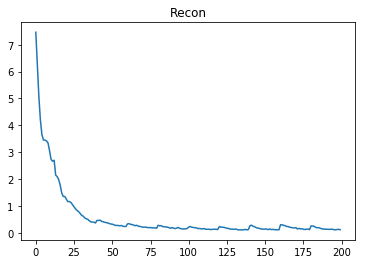

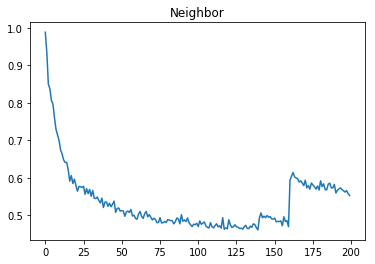

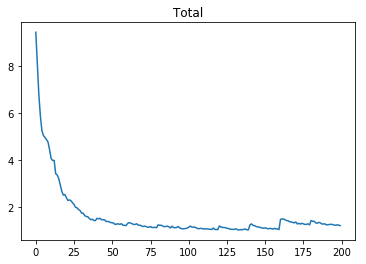

In [13]:
# pickle.dump((times, all_embeds), open('walkruns/' + str(init_epochs) + '.pkl', 'wb'))
plt.plot(list(range(len(label_losses))), label_losses)
plt.title("Recon")
plt.show()
    
plt.plot(list(range(len(edge_losses))), edge_losses)
plt.title("Neighbor")
plt.show()

plt.plot(list(range(len(total_losses))), total_losses)
plt.title("Total")
plt.show()

In [14]:
layout = nx.layout.kamada_kawai_layout(network)
# layout = nx.spring_layout(network)

C:\Users\jxbox\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
C:\Users\jxbox\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


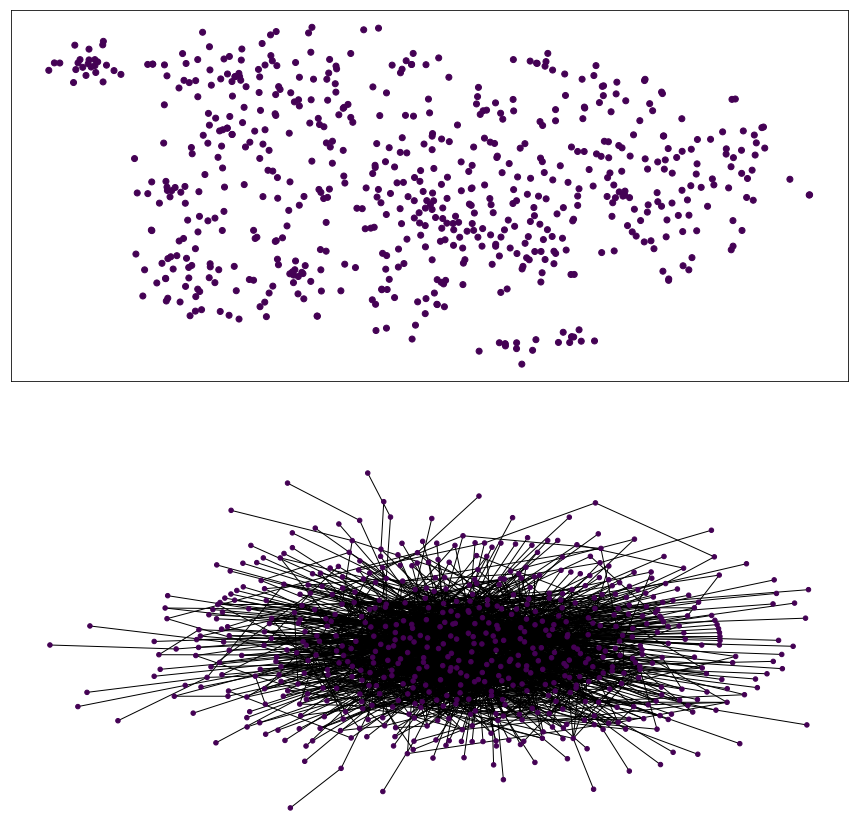

In [15]:
# embeddings = model.encode(data.x.float(), data.edge_index).detach().to("cpu")
model.eval()
with torch.no_grad():
    adj_mat = torch.tensor(nx.to_numpy_matrix(network)).to(device)
    _, embeddings, _, z, decoded = model(Data(adj_mat.float(), data.edge_index))
    # decoded, embeddings, var, z = model(data)
model.train()

decoded = decoded.detach().to("cpu")
embeddings = embeddings.detach().to("cpu")

# rands = np.random.choice(decoded.shape[0], 6)
# print(decoded[rands])
# print(adj_mat[rands])
# print(embeddings[rands])

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))

# attrs = [nx.get_node_attributes(network, 'classes')[i] for i in network.nodes]
# attrs = [nx.get_node_attributes(network, 'apt_markakis')[i] for i in network.nodes]
attrs = [0 for _ in network.nodes]

embeddings_2 = manifold.TSNE(n_components=2).fit_transform(embeddings)
# embeddings_2 = decomposition.PCA(n_components=2).fit_transform(embeddings)

ax1.scatter(embeddings_2[:,0], embeddings_2[:,1], c=attrs)
# ax1.scatter(embeddings_2[:,0], embeddings_2[:,1])

plt.setp((ax1, ax2), xticks=np.linspace(-0.1, 0.5, 0.05), xticklabels=np.linspace(-0.1, 0.5, 0.05),
        yticks=np.linspace(-0.1, 0.5, 0.05), yticklabels=np.linspace(-0.1, 0.5, 0.05))


# plt.sca(ax1)
# plt.xticks(np.linspace(-0.1, 0.5, 0.05))
# plt.yticks(np.linspace(-0.1, 0.5, 0.05))

nx.draw(network, node_color=attrs, pos=layout, node_size=20, ax=ax2)
# nx.draw(network, pos=layout, node_size=20, ax=ax2)

plt.show()

In [16]:
# %matplotlib inline

# attrs = [nx.get_node_attributes(network, 'apt_markakis')[i] for i in network.nodes]
# print("true attrs")
# nx.draw(network, node_color=attrs, pos=layout, node_size=20)
# plt.show()

# print("reconstructed attrs")
# nx.draw(network, node_color=preds.squeeze(), pos=layout, node_size=20)
# plt.show()

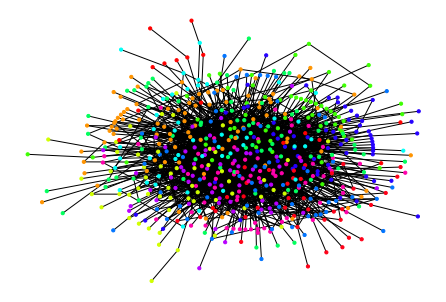

best communities
0.3363457068576643
num clusters 11


0.13452325201012377
0.12560811625144194
0.1318950259120883
0.146128079750693
0.13009805271947794
0.15268426852154748
0.1073909712298342
0.14598930803532997
0.1461825726141079
0.1415291575558272
0.12789965737504522
0.15050662006508153
0.1323001497908094
0.11996444620443864
0.14819570944026447
0.08396859558203199
0.09276088565968216
0.1709858645684475
0.1210060088497099
0.10992536285532273
0.1561195571701589
0.13149980200065428
0.140905287443398
0.16312021142886657
0.10452041114994576
0.11026256434978737
0.1377941151150979
0.11258105060174584
0.12619867082178338
0.13703801587438233



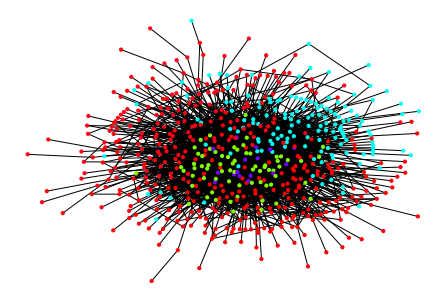

k means communities
0.13131939303157086 0.1709858645684475


In [17]:
%matplotlib inline
%matplotlib inline

network = nx.Graph(network)
communities = cm.best_partition(network)
best_vec = [communities.get(node) for node in network.nodes()]
mod = cm.modularity(communities,network)
community_vec = np.zeros(network.number_of_nodes())
# for idx, c in enumerate(communities):
#     c = [int(x) for x in c]
#     community_vec[c] = idx
    
nx.draw(network, pos=layout, node_size=10, node_color=best_vec, cmap='hsv')
# plt.savefig('communities.png')
num_coms = len(set(communities.values()))
plt.show()
print("best communities")
print(mod)

print("num clusters", num_coms)

mods = []
model.eval()
for _ in tqdm_notebook(range(10)):
    
    with torch.no_grad():
        _, embeddings, var, z, decoded = model(data)
        embeddings = embeddings.detach().to("cpu")
    
    clusters = cluster.KMeans(10).fit_predict(embeddings)
    cluster_dict = dict([(list(network.nodes)[i], clusters[i]) for i in range(len(clusters))])
    mods.append(cm.modularity(cluster_dict,network))
        
    print(mods[-1])
    
    clusters = cluster.KMeans(int(num_coms)).fit_predict(embeddings)
    cluster_dict = dict([(list(network.nodes)[i], clusters[i]) for i in range(len(clusters))])
    mods.append(cm.modularity(cluster_dict,network))
        
    print(mods[-1])
    
    clusters = cluster.KMeans(int(num_coms/2)).fit_predict(embeddings)
    cluster_dict = dict([(list(network.nodes)[i], clusters[i]) for i in range(len(clusters))])
    mods.append(cm.modularity(cluster_dict,network))
        
    print(mods[-1])
    
    print('============')
    
# clusters = cluster.AgglomerativeClustering(num_coms, connectivity=nx.to_numpy_matrix(network)).fit_predict(embeddings)
# mods.append(cm.modularity(cluster_dict,network))
nx.draw(network, pos=layout, node_size=10, node_color=clusters, cmap='hsv')
plt.show()
print("k means communities")
print(sum(mods) / len(mods), max(mods))
# # plt.savefig('kmeans.png')

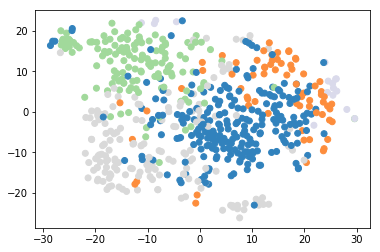

In [18]:
plt.scatter(embeddings_2[:,0], embeddings_2[:,1], c=clusters, cmap='tab20c')

In [19]:
# files = sorted([int(x[:-4]) for x in os.listdir('runs/embeddings/')])
# files = [str(x) + '.png' for x in files]

# with imageio.get_writer('runs/embedding_gifs/' + str(int(time.time())) + '.gif', mode='I', duration=0.35) as writer:
#     for f in files:
#         filename = 'runs/embeddings/' + f
#         image = imageio.imread(filename)
#         writer.append_data(image)


In [20]:
model.eval()

ks = [50, 250, 500, 1000, network.number_of_edges()]

with torch.no_grad():
    adj_mat = torch.tensor(nx.to_numpy_matrix(network)).to(device)
    _, embeddings, _, z, decoded = model(Data(adj_mat.float(), data.edge_index))
        
#     decoded = torch.zeros(decoded.shape).to(device)
        
#     for i in range(embeddings.shape[0]):
#         vals = nn.MSELoss(reduction='none')(embeddings[i].repeat(embeddings.shape[0], 1), embeddings)
#         decoded[i] = torch.sum(vals, dim=1)
    
#     decoded += torch.eye(decoded.shape[0]).to(device).float() * 1000
    
#     decoded[decoded < 0.5] = 1000
    
# torch.topk(decoded.view(-1), k=10, largest=False)

true_edges = list(network.edges())

for k in ks:

    topks = torch.topk(decoded.view(-1), k=k, largest=True)
    topks = topks.values.tolist()
    
    indices = (decoded >= topks[-1]).nonzero().tolist()
    
    print(len(indices))
    
    indices = [(str(x[0]), str(x[1])) for x in indices]

#     print(indices[:5])
#     print(list(network.edges())[:5])

    tp = list(set(indices).intersection(set(true_edges)))

    print("prec " + str(k) + ":", len(tp) / len(indices))
    print("===========")


50
prec 50: 0.94
250
prec 250: 0.852
500
prec 500: 0.764
1000
prec 1000: 0.598
2410
prec 2410: 0.42738589211618255


In [21]:
indices = (decoded > 0).nonzero().tolist()
indices = [(str(x[0]), str(x[1])) for x in indices]

true_edges = list(network.edges())

tp = list(set(indices).intersection(set(true_edges)))
    
# tp = [x for x in indices if x in list(network.edges())]

print("prec -1:", len(tp) / len(indices))

prec -1: 0.012150692811512882


In [22]:
# clusters = cluster.KMeans(7, n_init=250).fit_predict(embeddings.to("cpu").detach())

In [23]:
# knns = [[] for _ in range(7)]
# true_vals = [[] for _ in range(7)]
# for i in range(len(clusters)):
#         knns[clusters[i]].append(i)
#         true_vals[attrs[i]].append(i)
        
# intersects = []
        
# for i in range(7):
#     intersects.append([len(set(knns[i]).intersection(set(true_vals[j]))) / len(knns[i]) for j in range(7)])

# intersects = np.array(intersects)
    
# sbs.heatmap(intersects)

In [24]:
# vals = []
# perms = list(itertools.permutations(list(range(7))))
# for i in perms:
#     vals.append(sum(intersects[range(7), i]))
    
# new = perms[vals.index(max(vals))]

# remap = dict([(i, new[i]) for i in range(7)])

In [25]:
# clusters = [remap[i] for i in clusters]

# plt.scatter(embeddings_2[:,0], embeddings_2[:,1], c=clusters, cmap='Dark2')
# plt.show()

# max(vals)/7

In [26]:
# plt.scatter(embeddings_2[:,0], embeddings_2[:,1], c=attrs, cmap='Dark2')
# plt.show()

In [27]:
# # node2vec = Node2Vec(network, dimensions=12, workers=12)
# # model = node2vec.fit()

# # n2v_embeds = model.wv.vectors

# n2v_embeds = pickle.load(open('w2v_cora.emb', 'rb'))

# n2v_tsner = manifold.TSNE(n_components=2, n_iter=2500)
# n2v_tsne = n2v_tsner.fit_transform(n2v_embeds)

# plt.scatter(n2v_tsne[:, 0], n2v_tsne[:, 1], c=attrs, cmap='Dark2')
# plt.show()

# clusters = cluster.KMeans(7, n_init=250).fit_predict(n2v_embeds)

# knns = [[] for _ in range(7)]
# true_vals = [[] for _ in range(7)]
# for i in range(len(clusters)):
#         knns[clusters[i]].append(i)
#         true_vals[attrs[i]].append(i)
        
# intersects = []
        
# for i in range(7):
#     intersects.append([len(set(knns[i]).intersection(set(true_vals[j]))) / len(knns[i]) for j in range(7)])

# intersects = np.array(intersects)
    
# sbs.heatmap(intersects)
# plt.show()

# vals = []
# perms = list(itertools.permutations(list(range(7))))
# for i in perms:
#     vals.append(sum(intersects[range(7), i]))
    
# new = perms[vals.index(max(vals))]

# remap = dict([(i, new[i]) for i in range(7)])

# clusters = [remap[i] for i in clusters]

# plt.scatter(n2v_tsne[:,0], n2v_tsne[:,1], c=clusters, cmap='Dark2')
# plt.show()

# max(vals)/7

In [28]:
# pickle.dump(all_embeds, open('hepth/cora_embeds.pkl', 'wb'))